In [151]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import norm
from scipy.optimize import minimize
import sys
import pandas as pd

import io
from contextlib import redirect_stdout

import sys
sys.path.append('../pyJive/')
from utils import proputils as pu
import main
from names import GlobNames as gn
%matplotlib widget

In [152]:
def get_geom_file(y_list): 
    
    file = open('bridge.geom')
    filestring = file.read()

    split = filestring.split('\n')

    y_list = np.append(y_list, y_list[:-1][::-1])
    mod_indices = np.arange(3,20,2)

    count = 0
    for i in range(len(split)):
        split[i] += '\n'
        if i in mod_indices:
            linesplit = split[i].split(' ')
            linesplit[-1] = str(y_list[count]) + '\n'
            split[i] = ' '.join(linesplit)
            count += 1

    geom = ' '.join(split)

    with open("geomfile.geom", "w") as file:
        file.write(geom)
        
    return file.name

def eigenfrequencies(A_list, y_list):

    # Read the input file and store in props object
    props = pu.parse_file('bridge_frequency copy.pro')
    props['model']['truss']['area'] = A_list
    props['init']['mesh']['file'] = get_geom_file(y_list)
    
    
    # Call the program and store output in globdat
    trap = io.StringIO()
    with redirect_stdout(trap):
        globdat = main.jive(props)
    
    # Write additional output
    return(globdat[gn.EIGENFREQS][0:3]/2/np.pi)

def constraint(A_list, y_list, constr1=20, constr2=40, constr3=60):
    # convert first three natrual frequencies to Hz
    freq1, freq2, freq3 = eigenfrequencies(A_list, y_list)

    # calculate the violations of the constraints
    violation1 = max(0, constr1 - freq1)
    violation2 = max(0, constr2 - freq2)
    violation3 = max(0, constr3 - freq3)

    imag_parts = np.sum(np.imag([freq1, freq2, freq3]))
    
    #calculate the losses with the penalty
    total_violation = violation1 + violation2 + violation3 + imag_parts
    return total_violation

def mass_TRUSS(Areas, y_list, density=7800):
    
    x_coordinates=[0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10]
    y_coordinates = [0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
    y_coordinates[2] = y_list[0]
    y_coordinates[4] = y_list[1]
    y_coordinates[6] = y_list[2]
    y_coordinates[8] = y_list[3]
    y_coordinates[10] = y_list[4]
    y_coordinates[12] = y_list[3]
    y_coordinates[14] = y_list[2]
    y_coordinates[16] = y_list[1]
    y_coordinates[18] = y_list[0]
    
    #Calculate the lengths of the different elements
    Lengths = np.zeros(len(Areas))
    Lengths[0] = 1
    Lengths[1] = np.sqrt(x_coordinates[2]**2 + y_coordinates[2]**2)
    Lengths[2] = y_coordinates[2]
    Lengths[3] = np.sqrt((x_coordinates[2]-x_coordinates[3])**2 + (y_coordinates[2]-y_coordinates[3])**2)
    Lengths[4] = np.sqrt(1 + (y_coordinates[2]-y_coordinates[4])**2)
    Lengths[5] = y_coordinates[4]
    Lengths[6] = np.sqrt((x_coordinates[4]-x_coordinates[5])**2 + (y_coordinates[4]-y_coordinates[5])**2)
    Lengths[7] = np.sqrt(1 + (y_coordinates[4]-y_coordinates[6])**2)
    Lengths[8] = y_coordinates[6]
    Lengths[9] = np.sqrt((x_coordinates[6]-x_coordinates[7])**2 + (y_coordinates[6]-y_coordinates[7])**2)
    Lengths[10] = np.sqrt(1 + (y_coordinates[6]-y_coordinates[8])**2)
    Lengths[11] = y_coordinates[8]
    Lengths[12] = np.sqrt((x_coordinates[8]-x_coordinates[9])**2 + (y_coordinates[8]-y_coordinates[9])**2)
    Lengths[13] = np.sqrt(1 + (y_coordinates[8]-y_coordinates[10])**2)
    Lengths[14] = y_coordinates[10]
    
    #Calculate the volumes of the elements
    Volumes = Lengths * Areas
    
    #Calculate the total volume by summing the elements
    Total_Volume = 10*Volumes[0] + 2*(Volumes[1] + Volumes[2] + Volumes[3] + Volumes[4] + Volumes[5] + Volumes[6] + Volumes[7] + Volumes[9] + Volumes[10] + Volumes[11] + Volumes[12] + Volumes[13]) + Volumes[14]
    
    #Calculate the total mass
    Mass = Total_Volume * density
    
    return Mass


def loss_function(x_list, mass_penalty=1, constraint_penalty=1000000, Area_lower=4e-3):
    A_list = x_list[5:]
    A_list = np.append([Area_lower], A_list)
    y_list = x_list[0:5]
    mass = mass_TRUSS(A_list, y_list)
    total_loss = np.abs((constraint_penalty * constraint(A_list, y_list)) + (mass_penalty * mass))
    if (mass <= 0):
        total_loss += constraint_penalty * mass
    if constraint(A_list, y_list) != 0:
        print(f'The constraints for the natural frequencies are not met')
    else:
        print(f'The constraints of the natural frequencies are met')
    print(f'The total loss is:{total_loss}')
        
    return total_loss


def final_results(x_list, Area_lower=4e-3):
    A_list = x_list[5:]
    A_list = np.append([Area_lower], A_list)
    y_list = x_list[0:5]

    if constraint(A_list, y_list) != 0:
        print(f'The constraints for the natural frequencies are not met')
    else:
        print(f'The constraints of the natural frequencies are met')
        
    return mass_TRUSS(A_list, y_list), eigenfrequencies(A_list, y_list)

def costly_function(x):
    total = np.array([])
    for x_i in x:
        total = np.append(total, np.sum(np.exp(-(x_i - 5) ** 2)))
    
    return total + np.random.randn()

In [153]:
class BayesianOptimizer():
      
    def __init__(self, target_func, x_init, y_init, n_iter, batch_size):
        self.x_init = x_init
        self.y_init = y_init
        self.target_func = target_func
        self.n_iter = n_iter
        self.batch_size = batch_size
        self.gauss_pr = GaussianProcessRegressor()
        self.best_samples_ = pd.DataFrame(columns = ['x', 'y', 'ei'])
        self.distances_ = []


    def _get_expected_improvement(self, x_new):

        # Using estimate from Gaussian surrogate instead of actual function for 
        # a new trial data point to avoid cost

        mean_y_new, sigma_y_new = self.gauss_pr.predict(np.array(x_new).reshape(1, -1), return_std=True)
        #sigma_y_new = sigma_y_new.reshape(-1,1)
        if sigma_y_new[0] == 0.0:
            return 0.0
        
        # Using estimates from Gaussian surrogate instead of actual function for 
        # entire prior distribution to avoid cost
        
        mean_y = self.gauss_pr.predict(self.x_init)
        min_mean_y = np.min(mean_y)
        z = (mean_y_new - min_mean_y) / sigma_y_new
        exp_imp = (mean_y_new - min_mean_y) * norm.cdf(z) + sigma_y_new * norm.pdf(z)
        return exp_imp
    

    def _acquisition_function(self, x):
        return -self._get_expected_improvement(x)
        
        
    def _get_next_probable_point(self):
        min_ei = float(sys.maxsize)
        x_optimal = None 
                
        # Trial with an array of random data points
        
        for b in range(self.batch_size):
            x_start = Next_guess()
            response = minimize(fun=self._acquisition_function, x0=x_start, method='L-BFGS-B')
            # if response.fun[0] < min_ei:
            if response.fun < min_ei:
                # min_ei = response.fun[0]
                min_ei = response.fun
                x_optimal = response.x
            
        return x_optimal, min_ei
    
    
    def _extend_prior_with_posterior_data(self, x,y):
        self.x_init = np.append(self.x_init, np.array([x]), axis = 0)
        self.y_init = np.append(self.y_init, np.array([y]), axis = 0)
  

    def optimize(self):
        y_min_ind = np.argmin(self.y_init)
        y_min = self.y_init[y_min_ind]
        optimal_x = self.x_init[y_min_ind]
        optimal_ei = None
        for i in range(self.n_iter):
            self.gauss_pr.fit(self.x_init, self.y_init)
            x_next, ei = self._get_next_probable_point()
            y_next = self.target_func(np.array(x_next))
            self._extend_prior_with_posterior_data(x_next,y_next)

            if ((y_next < y_min) & (y_next > 0)):
                y_min = y_next
                optimal_x = x_next
                # optimal_ei = ei[0]
                optimal_ei = ei

            if i == 0:
                prev_x = x_next
            else:
                self.distances_.append(np.linalg.norm(prev_x - x_next))
                prev_x = x_next
                
            self.best_samples_ = pd.concat((self.best_samples_, pd.DataFrame({"y": [y_min], "ei": [optimal_ei]})), ignore_index=True)
            
        return optimal_x, y_min
            

In [160]:
def Initial_guess():
    y = np.random.uniform(1, 2, 5)
    Areas = np.random.uniform(0.002, 0.01, 14)

    x_list = np.append(y, Areas)
    return x_list

def Next_guess(y_bound=(0.5, 2), A_bound=(0.002, 0.01)):
    y = np.random.uniform(y_bound[0], y_bound[1], 5)
    Areas = np.random.uniform(A_bound[0], A_bound[1], 14)
    x_list = np.append(y, Areas)
    return x_list

In [164]:
x_list = []
y_list = []

n_samples = 15
for i in range(n_samples):
    x = Initial_guess()
    x_list.append(x)
    y_list.append(loss_function(x))

x_list = np.array(x_list)
y_list = np.array(y_list)
print(y_list)

The constraints of the natural frequencies are met
The total loss is:2414.247987859701
The constraints for the natural frequencies are not met
The total loss is:2564994.4344279263
The constraints of the natural frequencies are met
The total loss is:1867.564148356629
The constraints of the natural frequencies are met
The total loss is:2104.478109271111
The constraints for the natural frequencies are not met
The total loss is:12873603.29961198
The constraints of the natural frequencies are met
The total loss is:2235.429714184984
The constraints of the natural frequencies are met
The total loss is:2171.036110790219
The constraints for the natural frequencies are not met
The total loss is:2069092.5135136335
The constraints for the natural frequencies are not met
The total loss is:212236.39463208008
The constraints of the natural frequencies are met
The total loss is:2358.3024320918526
The constraints of the natural frequencies are met
The total loss is:2064.278944701197
The constraints of 

In [165]:
bopt = BayesianOptimizer(target_func=loss_function, x_init=x_list, y_init=y_list, n_iter=30, batch_size=50)
optimal_x, y_max = bopt.optimize()

The constraints for the natural frequencies are not met
The total loss is:45098860.6371418


C:\Users\31636\AppData\Local\Temp\ipykernel_20852\2174741547.py:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.best_samples_ = pd.concat((self.best_samples_, pd.DataFrame({"y": [y_min], "ei": [optimal_ei]})), ignore_index=True)


The constraints for the natural frequencies are not met
The total loss is:159528823.4344477
The constraints of the natural frequencies are met
The total loss is:1059.0626418325219


C:\Users\31636\AppData\Local\Temp\ipykernel_20852\2174741547.py:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.best_samples_ = pd.concat((self.best_samples_, pd.DataFrame({"y": [y_min], "ei": [optimal_ei]})), ignore_index=True)


The constraints for the natural frequencies are not met
The total loss is:30480796.44386666
The constraints for the natural frequencies are not met
The total loss is:3347502.3021196914
The constraints for the natural frequencies are not met
The total loss is:-649840918.6558623
The constraints for the natural frequencies are not met
The total loss is:26538072.66707245
The constraints for the natural frequencies are not met
The total loss is:55302223.04797887
The constraints for the natural frequencies are not met
The total loss is:78940404.3249087
The constraints for the natural frequencies are not met
The total loss is:88739499.63172208
The constraints for the natural frequencies are not met
The total loss is:149826428.95038483
The constraints for the natural frequencies are not met
The total loss is:28141496.745758653
The constraints for the natural frequencies are not met
The total loss is:35395794.92971797
The constraints for the natural frequencies are not met
The total loss is:127

In [170]:
m, f = final_results(optimal_x)
print(m)
print(f)

The constraints of the natural frequencies are met
1059.0626418325219
[20.5697853 +0.j 59.42039962+0.j 78.36790548+0.j]


Getting initial guesses

<Axes: >

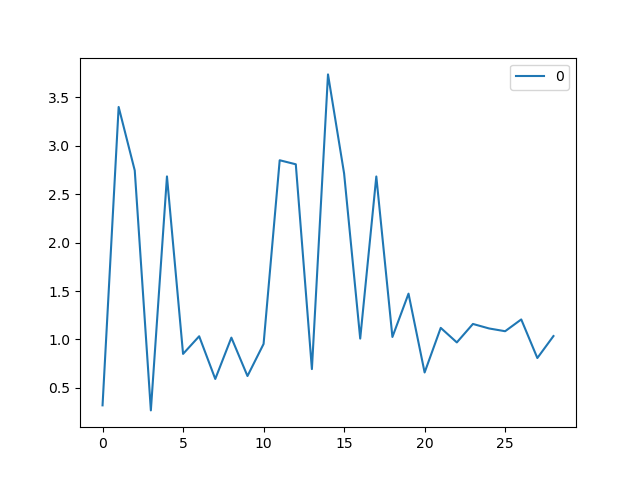

In [171]:
pd.DataFrame(bopt.distances_).plot()

<Axes: >

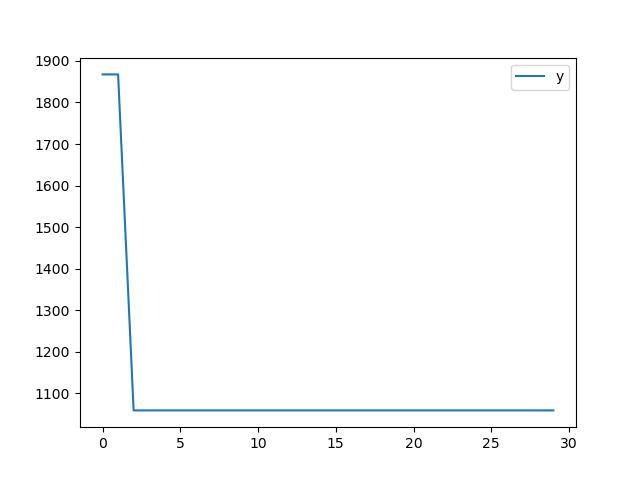

In [172]:
pd.DataFrame(bopt.best_samples_['y']).plot()

<Axes: >

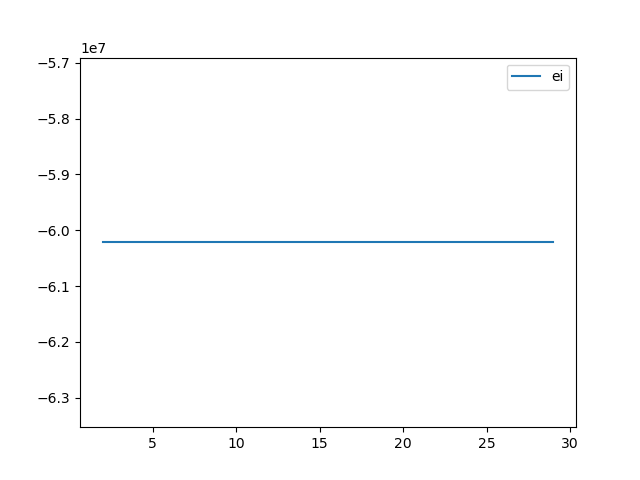

In [173]:
pd.DataFrame(bopt.best_samples_['ei']).plot()